C=0.1, Validation F1-score: 0.7187
C=1, Validation F1-score: 0.7624
C=10, Validation F1-score: 0.7550


c:\Users\mahen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C=100, Validation F1-score: 0.7226

Best model: C=1

Test Set Results:
True Positives: 618
True Negatives: 633
False Positives: 198
False Negatives: 213
Precision: 0.7574
Recall: 0.7437
F1-score: 0.7505


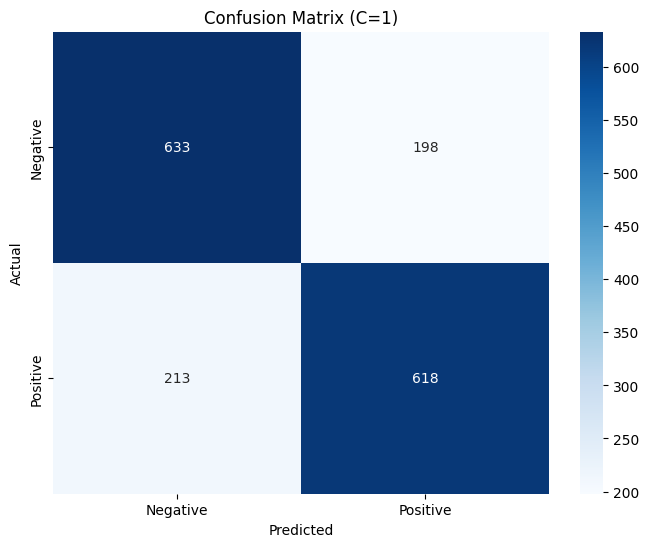

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Load and preprocess the data
pos_file = './rt-polaritydata/rt-polaritydata/rt-polarity.pos'
neg_file = './rt-polaritydata/rt-polaritydata/rt-polarity.neg'

with open(neg_file, 'r', encoding='latin-1') as neg_f:
    neg_reviews = neg_f.readlines()

with open(pos_file, 'r', encoding='latin-1') as pos_f:
    pos_reviews = pos_f.readlines()
    
neg_df = pd.DataFrame(neg_reviews, columns=["Review"])
neg_df['class'] = 0

pos_df = pd.DataFrame(pos_reviews, columns=["Review"])
pos_df['class'] = 1

train_data = pd.concat([neg_df.iloc[:4000], pos_df.iloc[:4000]])
val_data = pd.concat([neg_df.iloc[4000:4500], pos_df.iloc[4000:4500]])
test_data = pd.concat([neg_df.iloc[4500:], pos_df.iloc[4500:]])

X_train, y_train = train_data['Review'], train_data['class']
X_val, y_val = val_data['Review'], val_data['class']
X_test, y_test = test_data['Review'], test_data['class']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Function to evaluate model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')
    return tp, tn, fp, fn, precision, recall, f1

# Train and evaluate models with different C values
c_values = [0.1, 1, 10, 100]
best_model = None
best_f1 = 0

for c in c_values:
    model = LogisticRegression(C=c, random_state=42)
    model.fit(X_train_tfidf, y_train)
    
    # Evaluate on validation set
    _, _, _, _, _, _, f1 = evaluate_model(model, X_val_tfidf, y_val)
    
    print(f"C={c}, Validation F1-score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

print(f"\nBest model: C={best_model.C}")

# Evaluate best model on test set
tp, tn, fp, fn, precision, recall, f1 = evaluate_model(best_model, X_test_tfidf, y_test)

# Print results
print("\nTest Set Results:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")  

# Confusion matrix
y_test_pred = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix (C={best_model.C})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
